In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv("WSN-DS.csv")

In [13]:
df

,id,Time,Is_CH,who CH,Dist_To_CH,ADV_S,ADV_R,JOIN_S,JOIN_R,SCH_S,SCH_R,Rank,DATA_S,DATA_R,Data_Sent_To_BS,dist_CH_To_BS,send_code,Expaned Energy,Attack type
0,101000,50,1,101000,0.00000,1,0,0,25,1,0,0,0,1200,48,130.08535,0,2.46940,3
1,101001,50,0,101044,75.32345,0,4,1,0,0,1,2,38,0,0,0.00000,4,0.06957,3
2,101002,50,0,101010,46.95453,0,4,1,0,0,1,19,41,0,0,0.00000,3,0.06898,3
3,101003,50,0,101044,64.85231,0,4,1,0,0,1,16,38,0,0,0.00000,4,0.06673,3
4,101004,50,0,101010,4.83341,0,4,1,0,0,1,25,41,0,0,0.00000,3,0.06534,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374656,201096,1003,0,201051,6.98337,0,5,1,0,0,1,7,96,0,67,170.14779,3,0.15974,3
374657,201097,1003,0,201037,29.32867,0,5,1,0,0,1,31,39,0,24,82.21043,2,0.06877,3
374658,201098,1003,0,201095,18.51963,0,5,1,0,0,1,17,55,0,31,139.26438,1,0.09437,3
374659,201099,1003,0,201051,8.55001,0,5,1,0,0,1,3,96,0,65,158.27492,3,0.16047,3


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374661 entries, 0 to 374660
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0    id               374661 non-null  int64  
 1    Time             374661 non-null  int64  
 2    Is_CH            374661 non-null  int64  
 3    who CH           374661 non-null  int64  
 4    Dist_To_CH       374661 non-null  float64
 5    ADV_S            374661 non-null  int64  
 6    ADV_R            374661 non-null  int64  
 7    JOIN_S           374661 non-null  int64  
 8    JOIN_R           374661 non-null  int64  
 9    SCH_S            374661 non-null  int64  
 10   SCH_R            374661 non-null  int64  
 11  Rank              374661 non-null  int64  
 12   DATA_S           374661 non-null  int64  
 13   DATA_R           374661 non-null  int64  
 14   Data_Sent_To_BS  374661 non-null  int64  
 15   dist_CH_To_BS    374661 non-null  float64
 16   send_code        37

In [57]:
class_counts = df['Attack type'].value_counts()
print(class_counts)

3    340066
2     14596
0     10049
4      6638
1      3312
Name: Attack type, dtype: int64


In [17]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Attack type'] = label_encoder.fit_transform(df['Attack type'])

In [18]:
 #Encode the target variable
label_encoder = LabelEncoder()
df['Attack type'] = label_encoder.fit_transform(df['Attack type'])

# Split the data into features (X) and target (y)
X = df.drop(columns=['Attack type'])
y = df['Attack type']

In [20]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Reshape the input data to be 3D [samples, timesteps, features]
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [22]:
from keras.utils import to_categorical

# Assuming y_train and y_test are integer labels
y_train_encoded = to_categorical(y_train, num_classes=5)  # 5 classes
y_test_encoded = to_categorical(y_test, num_classes=5)

In [23]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (262262, 1, 18)
X_test shape: (112399, 1, 18)


In [24]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import numpy as np

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr  # Keep the initial learning rate for the first 5 epochs
    else:
        return lr * np.exp(-0.1)  # Decrease learning rate exponentially after the 5th epoch

# Create a Sequential model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Update input_shape
model.add(Dense(5, activation='softmax'))  # 5 classes for multi-class classification

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create a callback for learning rate scheduling
lr_schedule = LearningRateScheduler(lr_scheduler)

# Train the model with learning rate scheduling
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=64, validation_data=(X_test, y_test_encoded), callbacks=[lr_schedule], verbose=2)

# Predict class labels by finding the index of the maximum probability
y_pred_prob = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_prob, axis=1)


Epoch 1/20
4098/4098 - 19s - loss: 124.3633 - accuracy: 0.8690 - val_loss: 88.1609 - val_accuracy: 0.8989 - lr: 0.0010 - 19s/epoch - 5ms/step
Epoch 2/20
4098/4098 - 18s - loss: 67.4365 - accuracy: 0.8891 - val_loss: 71.0594 - val_accuracy: 0.8471 - lr: 0.0010 - 18s/epoch - 4ms/step
Epoch 3/20
4098/4098 - 16s - loss: 50.7186 - accuracy: 0.8998 - val_loss: 21.1478 - val_accuracy: 0.9270 - lr: 0.0010 - 16s/epoch - 4ms/step
Epoch 4/20
4098/4098 - 20s - loss: 45.0561 - accuracy: 0.9049 - val_loss: 29.4032 - val_accuracy: 0.9127 - lr: 0.0010 - 20s/epoch - 5ms/step
Epoch 5/20
4098/4098 - 17s - loss: 38.9868 - accuracy: 0.9090 - val_loss: 55.5483 - val_accuracy: 0.9162 - lr: 0.0010 - 17s/epoch - 4ms/step
Epoch 6/20
4098/4098 - 15s - loss: 30.5725 - accuracy: 0.9156 - val_loss: 77.6751 - val_accuracy: 0.9126 - lr: 9.0484e-04 - 15s/epoch - 4ms/step
Epoch 7/20
4098/4098 - 15s - loss: 22.0762 - accuracy: 0.9220 - val_loss: 6.7540 - val_accuracy: 0.9390 - lr: 8.1873e-04 - 15s/epoch - 4ms/step
Epoch

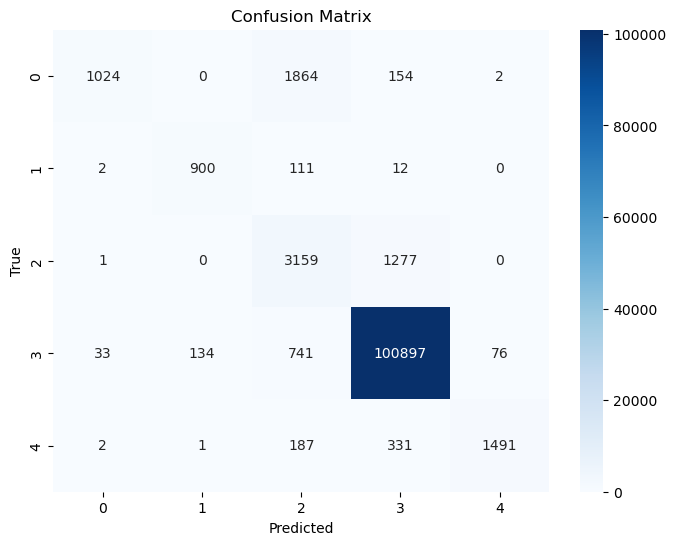

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


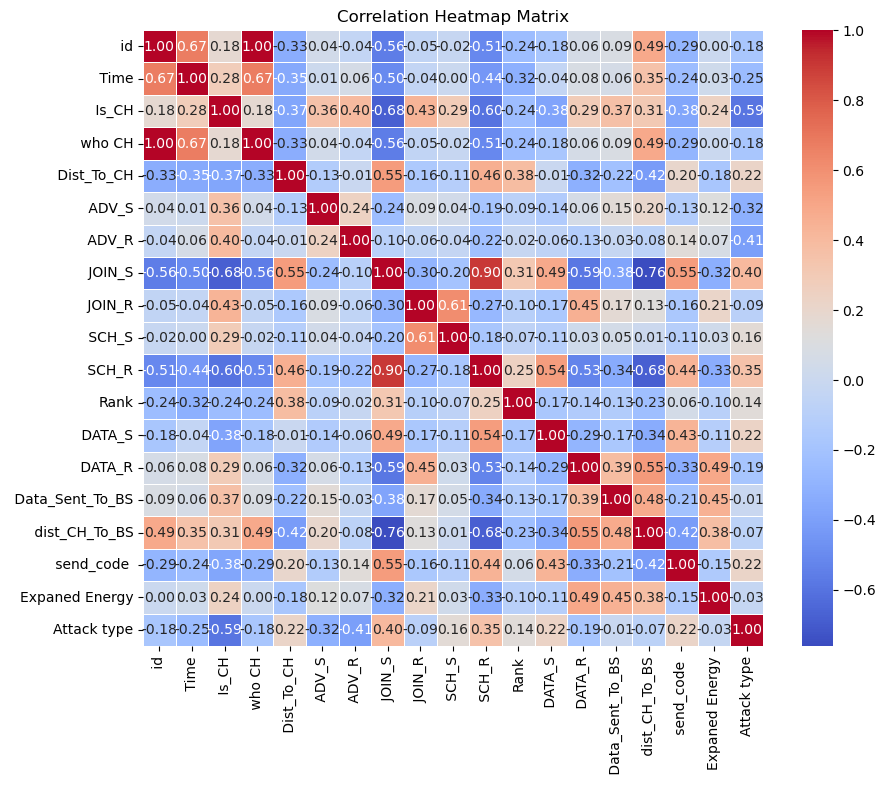

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'data' with your data
# Example:
# import pandas as pd
# df = pd.read_csv('your_dataset.csv')

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap Matrix")
plt.show()


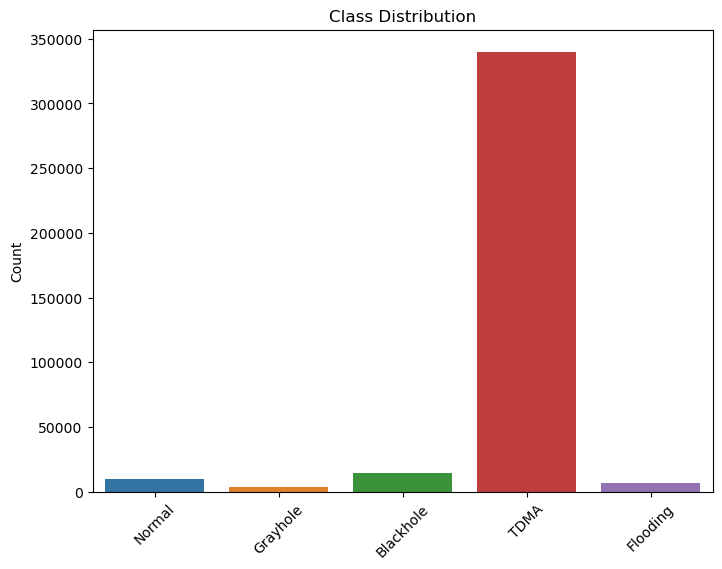

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame named 'data' with your data
# Example:
# import pandas as pd
# data = pd.read_csv('your_dataset.csv')

# Assuming 'target_column' is the column containing your categorical variable
# Example:
# target_column = 'class_label'

# Count the occurrences of each class
class_counts = df['Attack type'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution')
plt.ylabel('Count')

# Set custom x-axis tick labels
custom_labels = ['Normal', 'Grayhole', 'Blackhole', 'TDMA', 'Flooding']
plt.xticks(range(len(custom_labels)), custom_labels, rotation=45)

plt.show()


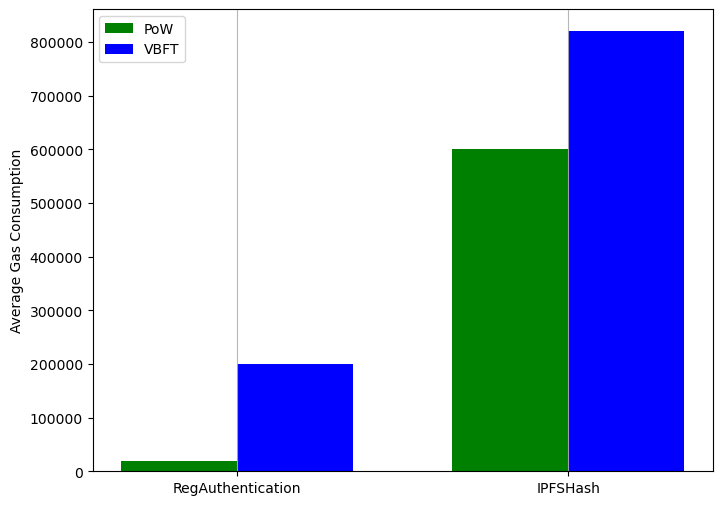

In [123]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data representing the number of smart contracts deployed
categories = ['RegAuthentication', 'IPFSHash']
reg_authentication = [200000, 820000]
ipfs_hash = [20000, 600000]

# Define the width of each bar
bar_width = 0.35

# Calculate the x-axis positions for the bars
x = np.arange(len(categories))

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the bars for "RegAuthentication" and "IPFSHash"
rects1 = ax.bar(x - bar_width/2,  ipfs_hash, bar_width, label='PoW', color='green')
rects2 = ax.bar(x + bar_width/2, reg_authentication, bar_width, label='VBFT', color='blue')

# Add labels and a title
plt.ylabel('Average Gas Consumption')
plt.xticks(x, categories)

# Add labels above each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
       
autolabel(rects2)
autolabel(rects1)

# Add a legend
ax.legend()

# Show the plot
plt.grid(axis='x', alpha=0.9)  
plt.show()
